In [2]:
from matplotlib.image import imread
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.fftpack import dct, idct
import pywt
from math import log10, sqrt 
import cv2 
import numpy as np 
from skimage.metrics import structural_similarity as SSIM
import os

In [3]:
def load_images(base_folder):
    images = []
    
    for subdir, dirs, files in os.walk(base_folder):
        for file in files:
            if file.lower().endswith((".tiff")):
                try:
                    file_path = os.path.join(subdir, file)
                    img = imread(file_path)
                    if img.ndim == 2:
                        img = img[:, :, np.newaxis]
                    images.append(img)
                except IOError:
                    print(f"Nie można załadować obrazu: {file_path}")
    return images
    

(256, 256, 3)


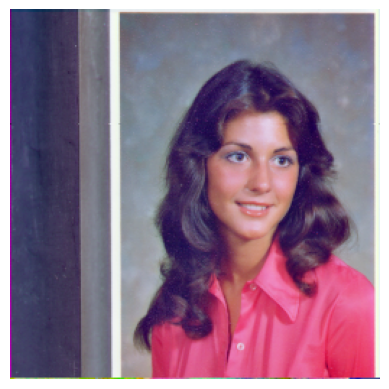

In [4]:
images = load_images('./data')

img = images[1]

plt.figure()
plt.imshow(img)
plt.axis('off')
print(img.shape)

In [5]:
def dct2(a):
    return dct(dct(a.T, norm='ortho').T, norm='ortho')

def idct2(a):
    return idct(idct(a.T, norm='ortho').T, norm='ortho')

def dct_compression(img, threshold=0.1):
    if len(img.shape) == 3 and img.shape[2] == 3:  # RGB image
        compressed_channels = []
        for i in range(3):
            channel_dct = dct2(img[:, :, i])
            channel_sort = np.sort(np.abs(channel_dct.reshape(-1)))

            thresh = channel_sort[int(np.floor((1 - threshold) * len(channel_sort)))]
            ind = np.abs(channel_dct) > thresh
            channel_compressed = channel_dct * ind
            channel_reconstructed = idct2(channel_compressed).real

            compressed_channels.append(channel_reconstructed)
        compressed_image = np.stack(compressed_channels, axis=-1)
    else: 
        channel_dct = dct2(img)
        channel_sort = np.sort(np.abs(channel_dct.reshape(-1)))

        thresh = channel_sort[int(np.floor((1 - threshold) * len(channel_sort)))]
        ind = np.abs(channel_dct) > thresh
        channel_compressed = channel_dct * ind
        compressed_image = idct2(channel_compressed).real

    compressed_image = np.clip(compressed_image, 0, 255).astype(np.uint8)
    if compressed_image.ndim == 2:
        compressed_image = np.expand_dims(compressed_image, axis=2)
    
    return compressed_image

1. Transformacja Fouriera: Najpierw, obraz jest przekształcany z dziedziny przestrzennej (czyli normalnego obrazu) do dziedziny częstotliwości za pomocą Transformacji Fouriera. Wynikową macierz nazywamy spektrum Fouriera, a jej elementy to współczynniki Fouriera, które zawierają informacje o amplitudzie i fazie różnych częstotliwości w obrazie.

2. Sortowanie Współczynników: Współczynniki Fouriera są sortowane według ich wartości bezwzględnych. Wartość bezwzględna tych współczynników odzwierciedla "ważność" lub "siłę" danej częstotliwości w reprezentacji obrazu.

3. Ustalenie Progu: Wartość progu jest ustalana na podstawie zadanej wartości threshold, która jest procentem (lub frakcją) współczynników, które chcemy zachować. Na przykład, jeśli threshold wynosi 0.1, to znaczy, że chcemy zachować 10% najważniejszych (największych) współczynników. Progowe ucięcie współczynników jest realizowane poprzez obliczenie indeksu, który odpowiada 90% (czyli 1 minus threshold) wszystkich posortowanych współczynników. Wartość współczynnika na tym indeksie staje się naszym progiem.

4. Maskowanie Współczynników: Tworzona jest maska binarna, która identyfikuje, które współczynniki są większe niż ustalony próg. Tylko współczynniki, które przekraczają ten próg, są zachowywane, a reszta jest zerowana.

5. Rekonstrukcja Obrazu: Po nałożeniu maski, zachowane współczynniki są używane do odwrotnej Transformacji Fouriera, aby przekształcić obraz z powrotem do dziedziny przestrzennej.

In [21]:
def fft_compression(img, threshold=0.1):

    if len(img.shape) == 3 and img.shape[2] == 3:
            compressed_channels = []
            
            for i in range(3):
                # Zastosuj 2-wymiarową Transformację Fouriera do bieżącego kanału.
                channel_dct = np.fft.fft2(img[:, :, i])
                
                # Posortuj współczynniki Fouriera według wartości bezwzględnej.
                channel_sort = np.sort(np.abs(channel_dct.reshape(-1)))

                # Ustal próg odcięcia na podstawie podanego parametru.
                thresh = channel_sort[int(np.floor((1 - threshold) * len(channel_sort)))]

                # Utwórz maskę identyfikującą współczynniki powyżej progu.
                ind = np.abs(channel_dct) > thresh

                # Zastosuj maskę, aby zachować tylko znaczące współczynniki.
                channel_compressed = channel_dct * ind
                
                # Zastosuj odwrotną Transformację Fouriera, aby uzyskać skompresowany kanał.
                channel_reconstructed = np.fft.ifft2(channel_compressed).real

                # Przechowaj odtworzony kanał.
                compressed_channels.append(channel_reconstructed)

        # Połącz skompresowane kanały w jeden obraz RGB.
            compressed_image = np.stack(compressed_channels, axis=-1)
            
    else:  # Grayscale image
            channel_dct = np.fft.fft2(img)
            channel_sort = np.sort(np.abs(channel_dct.reshape(-1)))

            thresh = channel_sort[int(np.floor((1 - threshold) * len(channel_sort)))]
            ind = np.abs(channel_dct) > thresh
            channel_compressed = channel_dct * ind
            compressed_image = np.fft.ifft2(channel_compressed).real

    compressed_image = np.clip(compressed_image, 0, 255).astype(np.uint8)
    if compressed_image.ndim == 2:
        compressed_image = np.expand_dims(compressed_image, axis=2)
    
    return compressed_image

In [7]:
def wavelet_compression(img, threshold=0.1):
    compressed_channels = []
    n = 4  # Level of wavelet decomposition
    wavelet_function = 'db1'  # Daubechies wavelet with one vanishing moment
    
    if img.ndim == 2:
        img = np.expand_dims(img, axis=2)
    
    if img.ndim == 3 and img.shape[2] == 3:  # RGB image
        for i in range(3):  # Process each channel individually
            coeffs = pywt.wavedec2(img[:, :, i], wavelet=wavelet_function, level=n, axes=(0, 1))
            coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs, axes=(0, 1))
            Csort = np.sort(np.abs(coeff_arr.reshape(-1)))

            thresh = Csort[int(np.floor((1 - threshold) * len(Csort)))]
            ind = np.abs(coeff_arr) > thresh
            Cfilt = coeff_arr * ind

            coeffs_filt = pywt.array_to_coeffs(Cfilt, coeff_slices, output_format='wavedec2')
            channel_reconstructed = pywt.waverec2(coeffs_filt, wavelet=wavelet_function, axes=(0, 1))
            compressed_channels.append(channel_reconstructed)
        compressed_image = np.stack(compressed_channels, axis=-1)

    else:  # Assuming Grayscale image
        coeffs = pywt.wavedec2(img, wavelet=wavelet_function, level=n, axes=(0, 1))
        coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs, axes=(0, 1))
        Csort = np.sort(np.abs(coeff_arr.reshape(-1)))

        thresh = Csort[int(np.floor((1 - threshold) * len(Csort)))]
        ind = np.abs(coeff_arr) > thresh
        Cfilt = coeff_arr * ind

        coeffs_filt = pywt.array_to_coeffs(Cfilt, coeff_slices, output_format='wavedec2')
        compressed_image = pywt.waverec2(coeffs_filt, wavelet=wavelet_function, axes=(0, 1))
        compressed_channels.append(compressed_image)

    compressed_image = np.clip(compressed_image, 0, 255).astype(np.uint8)  # Ensure pixel values are valid
    if compressed_image.ndim == 2:
        compressed_image = np.expand_dims(compressed_image, axis=2)

    return compressed_image

In [8]:
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0): 
        return 100
    
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    
    return psnr 

In [9]:
def SSIM_RGB(img1, img2):
    if img1.shape != img2.shape:
        raise ValueError("Input images must have the same dimensions")
    
    if len(img1.shape) == 3 and img1.shape[2] == 1:
        img1 = img1[:, :, 0]
        img2 = img2[:, :, 0]
        return SSIM(img1, img2, data_range=img1.max() - img1.min())

    elif len(img1.shape) == 3 and img1.shape[2] == 3:  # RGB images
        ssim_sum = 0.0
        for i in range(3):
            ssim_sum += SSIM(img1[:, :, i], img2[:, :, i], multichannel=True, data_range=255)
        return ssim_sum / 3.0

    elif len(img1.shape) == 2:
        return SSIM(img1, img2, data_range=img1.max() - img1.min())

    else:
        raise ValueError("Input images must have either 2 or 3 dimensions")


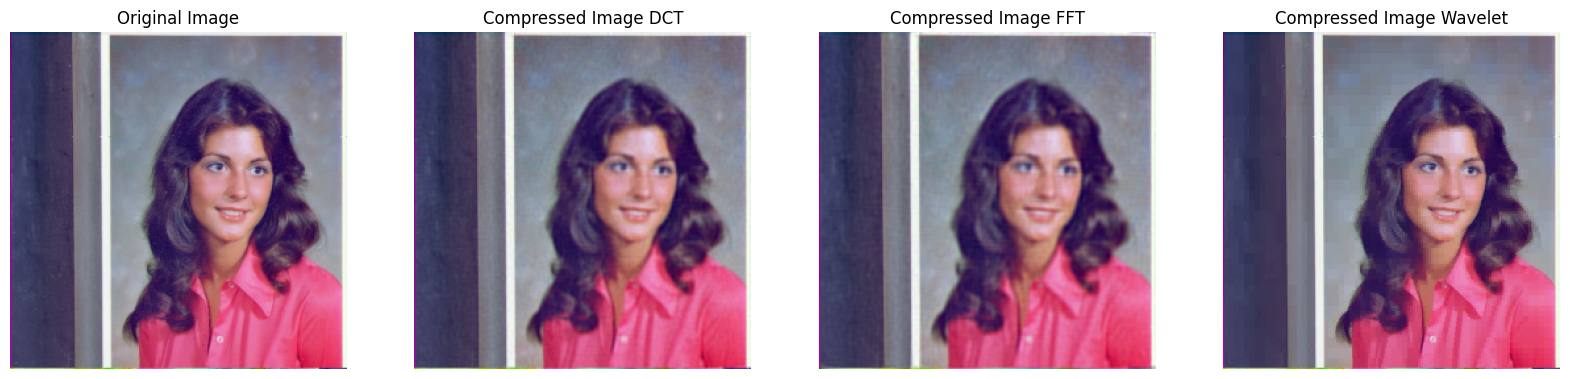

In [10]:
compressed_image_dct = dct_compression(img, threshold=0.1)
compressed_image_fft = fft_compression(img, threshold=0.1)
compressed_image_wavelet = wavelet_compression(img.squeeze(), threshold=0.1)

plt.figure(figsize=(20, 10))
plt.subplot(1, 4, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(compressed_image_dct.astype(np.uint8))
plt.title('Compressed Image DCT')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(compressed_image_fft.astype(np.uint8))
plt.title('Compressed Image FFT')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(compressed_image_wavelet.astype(np.uint8))
plt.title('Compressed Image Wavelet')
plt.axis('off')
plt.show()

In [11]:
print('PSNR Wavelets:', PSNR(img, compressed_image_wavelet))
print('PSNR fft:', PSNR(img, compressed_image_fft))
print('PSNR dct:', PSNR(img, compressed_image_dct))

PSNR Wavelets: 36.28818860236067
PSNR fft: 35.56123621441527
PSNR dct: 36.56427509755538


In [12]:
print('SSIM Wavelets:', SSIM_RGB(img, compressed_image_wavelet))
print('SSIM fft:', SSIM_RGB(img, compressed_image_fft))
print('SSIM dct:', SSIM_RGB(img, compressed_image_dct))

SSIM Wavelets: 0.9176642072908665
SSIM fft: 0.9088798813108173
SSIM dct: 0.9253920874047528


In [19]:
def average_ssim(list_images1, list_images2):
    if len(list_images1) != len(list_images2):
        raise ValueError("Both lists must contain the same number of images.")
    
    total_ssim = 0.0
    num_images = len(list_images1)
    
    for img1, img2 in zip(list_images1, list_images2):
        if img1.shape != img2.shape:
            print(img1.shape, img2.shape)
            raise ValueError("All images in the pairs must have the same dimensions.")
        
        current_ssim = SSIM_RGB(img1, img2)
        total_ssim += current_ssim
    
    return total_ssim / num_images

In [18]:
def average_pnsr(list_images1, list_images2):
    if len(list_images1) != len(list_images2):
        raise ValueError("Both lists must contain the same number of images.")
    
    total_psnr = 0.0
    num_images = len(list_images1)
    
    for img1, img2 in zip(list_images1, list_images2):
        if img1.shape != img2.shape:
            raise ValueError("All images in the pairs must have the same dimensions.")
        
        current_psnr = PSNR(img1, img2)
        total_psnr += current_psnr
    
    return total_psnr / num_images

In [15]:
compressed_images_dct = [dct_compression(img) for img in images]

avg_ssim_dct = average_ssim(images, compressed_images_dct)
avg_pnsr_dct = average_pnsr(images, compressed_images_dct)

(0.7490029680035684, 32.1508301541331)

In [16]:
compressed_images_fft = [fft_compression(img) for img in images]

avg_ssim_fft = average_ssim(images, compressed_images_fft)
avg_pnsr_fft = average_pnsr(images, compressed_images_fft)

(0.7519582581758395, 32.14482099830737)

In [17]:
compressed_images_wavelets = [wavelet_compression(img) for img in images]

avg_ssim_wavelets = average_ssim(images, compressed_images_wavelets)
avg_pnsr_wavelets = average_pnsr(images, compressed_images_wavelets)

(0.845550007629806, 34.85281005001279)

In [20]:
print(f'Średni SSIM dla DCT= {avg_ssim_dct}, Średni PNSR dla DCT= {avg_pnsr_dct}')
print(f'Średni SSIM dla FFT= {avg_ssim_fft}, Średni PNSR dla DCT= {avg_pnsr_fft}')
print(f'Średni SSIM dla Wavelets= {avg_ssim_wavelets}, Średni PNSR dla Wavelets= {avg_pnsr_wavelets}')

Średni SSIM dla DCT= 0.7490029680035684, Średni PNSR dla DCT= 32.1508301541331
Średni SSIM dla FFT= 0.7519582581758395, Średni PNSR dla DCT= 32.14482099830737
Średni SSIM dla Wavelets= 0.845550007629806, Średni PNSR dla Wavelets= 34.85281005001279
